
# Does the Number of Reviews Influence the Ratings?

An interesting data set from Kaggle, [Wine Rating & Price](https://www.kaggle.com/datasets/budnyak/wine-rating-and-price?select=White.csv) highlighted the notion that reviews are not evenly distributed and proposed that consumers are hesitant to try new wines from vineyards that have a small number of total reviews. 

Should consumer believe that the small reviews indicate less accurate ratings? Do popular wines natural attract more reviews because they are better? Are nations with smaller set of reviewers at a disadvantage and are scored lower on average?

## The Data
The data has been loaded into a SQLite database and is contains the white and red wine tables: The Table structure is below.

* Name - Name of the wine
* Country - The country of origin
* Region - Region/province where the wine was produced
* Winery - The winery that produces the wine
* Rating - The average rating assigned to the wine
* NumberOfRatings - The number of people who rated the wine.
* Price - The price of the wine (EUR).
* Year - Year of production.

In [380]:
import pandas as pd
import seaborn as sns
import sqlite3
import contextlib
import io
import numpy as np
from scipy.stats import wilcoxon
output = io.StringIO()

In [381]:
%load_ext sql
%sql sqlite:///wine.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Are Reviews Skewed to Specific Countries?
We'll validate the notion that wines from certain countries get more review than others. We'll query the table for only red wine for this example and plot the resulting distribution.

In [382]:
query  = '''
WITH total_reviews AS (
    SELECT
        country,
        SUM(NumberOfRatings) AS total_ratings,
        SUM(NumberOfRatings) * 1.0 / SUM(SUM(NumberOfRatings)) OVER() AS per_of_total
    FROM red_wine
    GROUP BY country
    ORDER BY total_ratings
)
SELECT
    country,
    total_ratings,
    per_of_total,
    SUM(per_of_total) OVER (ORDER BY per_of_total desc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_sum
FROM total_reviews
GROUP BY country
ORDER BY total_ratings desc
'''

result = %sql {query}
df= result.DataFrame()


 * sqlite:///wine.db
Done.


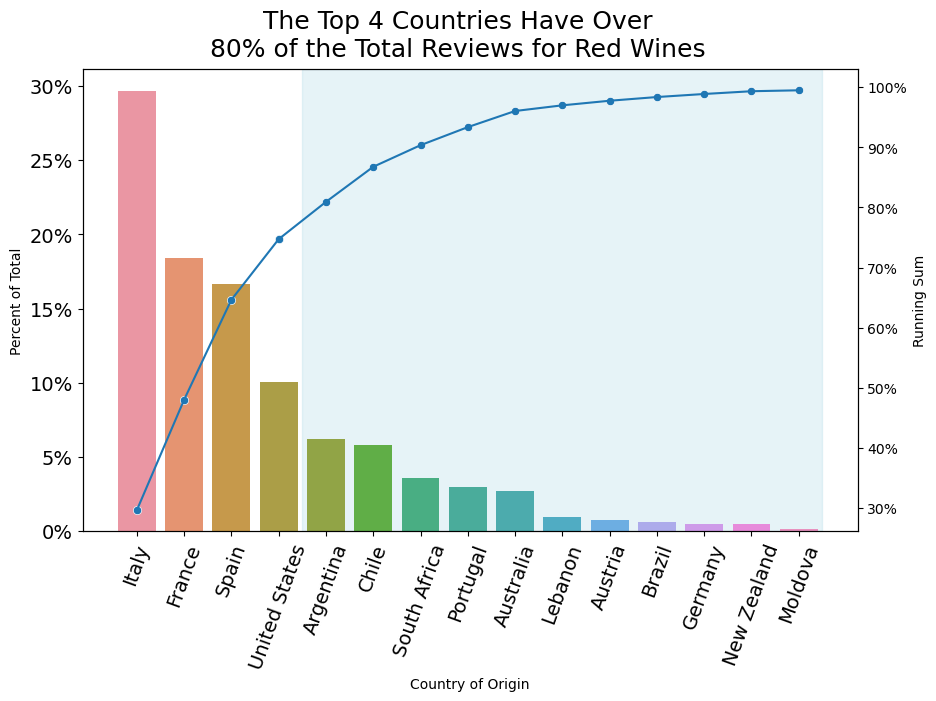

In [383]:
# ----- Plot the Pareto Chart ------ #
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

fig, axes = plt.subplots(figsize = (10,6))
df_temp = df[df['running_sum']<.995] # Trimming the data to keep the chart organized

sns.barplot(data=df_temp, x='country', y='per_of_total')
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.suptitle('The Top 4 Countries Have Over\n80% of the Total Reviews for Red Wines',fontsize=18)
axes.set_xlabel('Country of Origin')
axes.set_ylabel('Percent of Total')
axes.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))  # xmax=1 if values are between 0 and 1

# ----- Plot Running Sum ----- #
twin_x = axes.twinx()

sns.scatterplot(data=df_temp,x='country', y='running_sum')
sns.lineplot(data=df_temp,x='country', y='running_sum')
twin_x.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))  # xmax=1 if values are between 0 and 1
twin_x.set_ylabel('Running Sum')

# ----- Plot 80% Threshold ---- #
max_idx = df_temp[df_temp['running_sum'] <=0.80].index.max() + .5
max_y = df_temp['per_of_total'].max()
axes.axvspan(xmin=max_idx, xmax=len(df_temp)-.5, color='lightblue', alpha=0.3,zorder=-1)  # Use the x-values based on your data

plt.show()

The distribution of review is notably skewed, with four nations accounting for over 80% of the total review on the website.

Although many factors may contribute to this, exploring them is outside the scope of our current investigation.

For now, we will move forward with testing if there is a significant statistical relationship between the average rating and the total number of reviews across different countries.

## Putting _'More Reviews, Better Rating'_ to the Test


### Mann - Whitney U Test
We'll use the Mann-Whitney U test, a non-parametric statistical test used to compare the differences between two independent variables or groups. It checks if one group's values are statistically greater than the other.

In our test, we select the number of review and the average national rating as our independent values and we'll to classify the ratings into either 'high' or 'low' groups.

The Mann-Whitney U test does not assume normality of the data which is beneficial since the total reviews is heavily right skewed as shown below.

 * sqlite:///wine.db
Done.


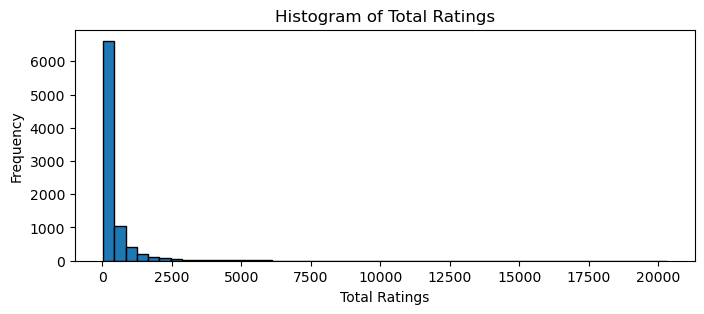

In [384]:
query  = '''
    SELECT
    NumberOfRatings as total_ratings
    FROM red_wine
    ORDER BY total_ratings
'''
result = %sql {query}
df = result.DataFrame()
df['total_ratings'].plot.hist(bins=50, edgecolor= 'black', figsize=(8, 3))  
plt.title('Histogram of Total Ratings')
plt.xlabel('Total Ratings')
plt.ylabel('Frequency')
plt.show()

#### Null Hypothesis $(H_0)$

We will establish our null hypothesis as such: 
 
 >$H_0$: There is no statistically significant difference in the total number of review between highly rate (above 3.77) and lowly rate (below 3.77) rated red wines across countries from 2016 or later.

In this context, 3.77 is the median of the average wine ratings across nations and was chosen to classify a nation's wine as either 'High' (in the top 50th percentile) or 'Low' (in the bottom 50th percentile).

#### Extracting the Data
We will extract the ratings and total number of reviews. We'll then group the rating data into 'High' or 'Low' ratings based on the median value of 3.77. Then rank each country based on the total number of reviews.


In [385]:
%%sql
WITH ranked_wines AS (
    SELECT 
            country, 
            ROUND(avg(rating), 1) as rating,
            SUM(NumberOfRatings) AS total_ratings,
            CASE 
                WHEN AVG(rating) >= 3.77 THEN 'High'
                ELSE 'Low'
            END AS grouping,
            RANK() OVER(ORDER BY SUM(NumberOfRatings) ASC) AS rank
        FROM red_wine 
        WHERE YEAR > 2015
        GROUP BY country
        ORDER BY SUM(NumberOfRatings) 
)
SELECT * 
FROM ranked_wines


 * sqlite:///wine.db
Done.


country,rating,total_ratings,grouping,rank
Bulgaria,3.7,40,Low,1
Croatia,4.2,44,High,2
Canada,3.3,96,Low,3
China,2.9,235,Low,4
Georgia,4.3,272,High,5
Turkey,3.7,361,Low,6
Hungary,3.7,578,Low,7
Switzerland,3.9,683,High,8
Slovenia,3.7,919,Low,9
Romania,3.6,1535,Low,10


Next, We'll sum the rank values for the 'High' and 'Low' groupings to compare the distribution of each groups ranking.

In [386]:
%%sql
WITH ranked_wines AS (
    SELECT 
            country, 
            ROUND(avg(rating), 1) as rating,
            SUM(NumberOfRatings) AS total_ratings,
            CASE 
                WHEN AVG(rating) >= 3.77 THEN 'High'
                ELSE 'Low'
            END AS grouping,
            RANK() OVER(ORDER BY SUM(NumberOfRatings) ASC) AS rank
        FROM red_wine 
        WHERE YEAR > 2015
        GROUP BY country
        ORDER BY SUM(NumberOfRatings) 
),
sum_of_ranks AS (
    SELECT
        grouping,
        SUM(rank) as total_rank,
        COUNT(*) as n
        FROM ranked_wines
        GROUP BY grouping
)
SELECT *
FROM sum_of_ranks


 * sqlite:///wine.db
Done.


grouping,total_rank,n
High,225,14
Low,181,14


Now that we have the sum of ranks and the number of observations in each group we will calculate the U1 and U2 values. The minimum of U1 and U2 will serve as our test statistic $U$. 

In [387]:
%%sql
WITH ranked_wines AS (
    SELECT 
            country, 
            ROUND(avg(rating), 1) as rating,
            SUM(NumberOfRatings) AS total_ratings,
            CASE 
                WHEN AVG(rating) >= 3.77 THEN 'High'
                ELSE 'Low'
            END AS grouping,
            RANK() OVER(ORDER BY SUM(NumberOfRatings) ASC) AS rank
        FROM red_wine 
        WHERE YEAR > 2015
        GROUP BY country
        ORDER BY SUM(NumberOfRatings) 
),
sum_of_ranks AS (
    SELECT
        grouping,
        SUM(rank) as total_rank,
        COUNT(*) as n
        FROM ranked_wines
        GROUP BY grouping
),
u_statistic AS (
    -- Transforming table into a single row
    SELECT 
        SUM(CASE 
            WHEN grouping = 'High' THEN total_rank
            ELSE 0 
        END) AS high_group_ranks,
        SUM(CASE 
            WHEN grouping = 'Low' THEN total_rank
            ELSE 0 
        END) AS low_group_ranks,
        MAX(CASE 
            WHEN grouping = 'High' THEN n
            ELSE 0 
        END) AS n1,
        MAX(CASE 
            WHEN grouping = 'Low' THEN n
            ELSE 0 
        END) AS n2
    FROM sum_of_ranks 
)
SELECT 
    (n1 * n2) + (n1 * (n1 + 1)) / 2 - high_group_ranks as U1,
    (n1 * n2) + (n2 * (n2 + 1)) / 2 - low_group_ranks as U2,
    MIN(((n1 * n2) + (n1 * (n1 + 1)) / 2 - high_group_ranks),
    ((n1 * n2) + (n2 * (n2 + 1)) / 2 - low_group_ranks)) as test_value,
    n1,
    n2
FROM u_statistic


 * sqlite:///wine.db
Done.


U1,U2,test_value,n1,n2
76,120,76,14,14


### Critical Value Lookup

![mann whitney table](./tables/mann-whitney-alpha-10a.png)


Using the above chart for $n_1$ = $n_2$ = 14, the critical value $U_{critical}$ is 61. We determined from the last query our test value $U$ is 76

Since  $U > U_{critical}$, the null hypothesis stands.
 >$H_0$: There is no statistically significant difference in the total number of review between highly (above 3.77) and lowly (below 3.77) rated red wines across countries from 2016 or later.


We can validate our findings by using SciPy's method for the Mann-Whitney U test and passing it the 'Low' and 'High' groups' data.

In [388]:
import pandas as pd
from scipy.stats import mannwhitneyu

In [389]:
query= '''
WITH ranked_wines AS (
    SELECT 
            country, 
            round(avg(rating), 1) as rating,
            SUM(NumberOfRatings) AS total_ratings,
            CASE 
                WHEN AVG(rating) >= 3.77 THEN 'High'
                ELSE 'Low'
            END AS grouping,
            RANK() OVER(ORDER BY SUM(NumberOfRatings) ASC) AS rank
        FROM red_wine 
        WHERE YEAR > 2015
        GROUP BY country
        ORDER BY SUM(NumberOfRatings) 
)
SELECT * 
FROM ranked_wines
'''
result = %sql {query}
df = result.DataFrame()


 * sqlite:///wine.db
Done.


In [390]:
low_rated = df[df['grouping'] =='Low']['total_ratings']
high_rated = df[df['grouping'] =='High']['total_ratings']
n1 = len(low_rated)
n2 = len(high_rated)

stat, p_value = mannwhitneyu(low_rated, high_rated, alternative='two-sided')
stat = min(stat, n1*n2 - stat) # Getting the smallest U value

# ----- Print Results ----- #
print('Scipy\'s Mann-Whiteny U method')
print(f'U min: {stat}')
print(f'p value: {p_value:.3f}')
if p_value > 0.05:
    print("p-value > 0.05: There is no statistically significant relationship between the two independent variables.")
else:
    print("p-value <= 0.05. A statistically significant relationship between the two independent variables does exist.")
print('_' * 50)

Scipy's Mann-Whiteny U method
U min: 76.0
p value: 0.323
p-value > 0.05: There is no statistically significant relationship between the two independent variables.
__________________________________________________


Everything checks out. Our findings using SQL and the look up table match the results from the SciPy function.

## Findings

Based on the Mann-Whitney U test results, we could not rejected the null hypothesis, and so we found no significant positive relationship between the number of reviews and whether a nations wine's was rated on average in the top 50% or bottom 50% of wines.

Based on out analysis, we can comfortable state that :
1. The number of reviews for a country's wine does not significantly affect its average rating
2. The lack of reviews does not necessarily result lower average ratings
3. A higher number of reviews does not guarantee a higher average rating
___

## Bonus Question

Suppose we are curious to see if red and white wine are rating significantly different from each other. Are red wines often rated higher than white wines, or vice versa, over the years? What about across countries? Do some nations produce more highly rated white or red wines?

## Wilcox Signed Test
For this analysis we will use another nonparametric test, the Wilcoxon Signed-Rank test, which is suitable for paired observations such as types of wine produced by the same country. 

We will conduct a two-tailed Wilcoxon Signed-Ranks Test with significance level of α = .05 to test the following null hypothesis:

 >$H_0$: There is no statistically significant difference in the average rating of a country's red and white wine over the years.

_Note: While we could apply a paired t-test after checking for the normality of the rating differences, we we'll use Wilcox Signed-Rank test for practice._

### Methodology and Data Retrieval

We'll conduct the retrieval and calculations using the following steps:
1. Retrieve the average ratings of red and white wine, grouped by year and country (_We'll filter for __Italy__ to start with_)
2. Join the two tables, then calculate the difference and absolute difference between the average ratings for each year and country
3. Rank, with ties, each record by the absolute difference in ascending order
4. Sum the rank values for when the difference is negative as $T^-$ and when it is positive as $T^+$
5. Take the test statistic to be the minimum of $T^+$ and $T^-$ with $n$ as the number of paired observations

In [391]:
%%sql
WITH red_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_red_rating, Country
    FROM red_wine
    GROUP BY year, Country
),
white_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_white_rating, Country
    FROM white_wine
    GROUP BY year, Country
),
absolute_diff_ranked AS (
    SELECT
        red_avg.Country,
        red_avg.year,
        red_avg.avg_red_rating,
        white_avg.avg_white_rating,
        ROUND(red_avg.avg_red_rating - white_avg.avg_white_rating, 3) AS diff,
        ROUND(ABS(red_avg.avg_red_rating - white_avg.avg_white_rating), 3) AS abs_diff,
        RANK() OVER(ORDER BY ABS(red_avg.avg_red_rating - white_avg.avg_white_rating) ASC) AS rank
    FROM red_avg
    JOIN white_avg ON red_avg.year = white_avg.year AND red_avg.Country = white_avg.Country
    WHERE red_avg.year <> 'N.V.' AND diff <> 0 AND red_avg.Country = 'Italy'
),
signed_ranks as (
SELECT
*,
CASE
    WHEN diff>0 THEN rank ELSE NULL END as pos_ranks,
CASE
    WHEN diff<0 THEN rank ELSE NULL END as neg_ranks
FROM absolute_diff_ranked
)
SELECT
* FROM 
signed_ranks

 * sqlite:///wine.db
Done.


Country,year,avg_red_rating,avg_white_rating,diff,abs_diff,rank,pos_ranks,neg_ranks
Italy,2015,3.982,3.979,0.003,0.003,1,1,None
Italy,2010,4.162,4.15,0.012,0.012,2,2,None
Italy,2018,3.728,3.753,-0.025,0.025,3,None,3
Italy,2008,4.135,4.1,0.035,0.035,4,4,None
Italy,2016,3.931,3.889,0.042,0.042,5,5,None
Italy,2012,4.094,4.05,0.044,0.044,6,6,None
Italy,2017,3.82,3.769,0.051,0.051,7,7,None
Italy,2014,3.948,4.03,-0.082,0.082,8,None,8
Italy,2011,4.099,4.0,0.099,0.099,9,9,None
Italy,2019,3.713,3.822,-0.109,0.109,10,None,10


Above is the retrieved data for Italy. We have calculated the average rating for each wine type across the years and ranked them by absolute difference.

We'll further handle the data by summing the ranks of the positive difference values (pos_ranks), the negative difference values (neg_ranks), and count the total number of paired observations.

In [392]:
%%sql
WITH red_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_red_rating, Country
    FROM red_wine
    GROUP BY year, Country
),
white_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_white_rating, Country
    FROM white_wine
    GROUP BY year, Country
),
absolute_diff_ranked AS (
    SELECT
        red_avg.Country,
        red_avg.year,
        red_avg.avg_red_rating,
        white_avg.avg_white_rating,
        ROUND(red_avg.avg_red_rating - white_avg.avg_white_rating, 3) AS diff,
        ROUND(ABS(red_avg.avg_red_rating - white_avg.avg_white_rating), 3) AS abs_diff,
        RANK() OVER(ORDER BY ABS(red_avg.avg_red_rating - white_avg.avg_white_rating) ASC) AS rank
    FROM red_avg
    JOIN white_avg ON red_avg.year = white_avg.year AND red_avg.Country = white_avg.Country
    WHERE red_avg.year <> 'N.V.' AND diff <> 0 AND red_avg.Country = 'Italy'
),
signed_ranks as (
SELECT
*,
CASE
    WHEN diff>0 THEN rank ELSE NULL END as pos_ranks,
CASE
    WHEN diff<0 THEN rank ELSE NULL END as neg_ranks
from absolute_diff_ranked
)
Select
SUM(pos_ranks) as "T+",
SUM(neg_ranks) as "T-",
MIN(SUM(pos_ranks),SUM(neg_ranks)) as "test_stat",
count(*) as n
from signed_ranks;

 * sqlite:///wine.db
Done.


T+,T-,test_stat,n
70,21,21,13


### Critical Value Table

The test statistic from our result, $W$ is 21 with $n = 13$ observations. The critical value $W_{crit} = 17$ for $a = 0.05$ and $n = 13 $ 

Since $W > W_{crit}$ we cannot reject the null hypothesis.

>$H_0$: There is no statistically significant difference in the average rating of a country's (in this specific case Italy's) red and white wine over the years.


![signed rank table](./tables/signed-ranks-table.png)

### What about other Countries?

Initially, we hardcoded a ```WHERE``` statement to filter for Italy, but ideally we want to conduct the test for each country. To achieve this, we will modify the SQL query to specifically rank by partitioning and grouping over the country field. Additionally, we will  filter any nations with fewer than five observations since the test requires five or more.

In [393]:
query = f''' 
    WITH red_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_red_rating, Country
    FROM red_wine
    GROUP BY year, Country
),
white_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_white_rating, Country
    FROM white_wine
    GROUP BY year, Country
),
absolute_diff_ranked AS (
    SELECT
        red_avg.Country,
        red_avg.year,
        red_avg.avg_red_rating,
        white_avg.avg_white_rating,
        ROUND(red_avg.avg_red_rating - white_avg.avg_white_rating, 3) AS diff,
        ROUND(ABS(red_avg.avg_red_rating - white_avg.avg_white_rating), 3) AS abs_diff,
        RANK() OVER(PARTITION BY red_avg.country ORDER BY ABS(red_avg.avg_red_rating - white_avg.avg_white_rating) ASC) AS rank
    FROM red_avg
    JOIN white_avg ON red_avg.year = white_avg.year AND red_avg.Country = white_avg.Country
    WHERE red_avg.year <> 'N.V.' AND diff <> 0
    GROUP BY red_avg.Country, red_avg.year
    order by red_avg.Country, red_avg.year
),
signed_ranks AS (
    SELECT
        *,
        CASE
            WHEN diff>0 THEN rank ELSE 0 END AS pos_ranks,
        CASE
            WHEN diff<0 THEN rank ELSE 0 END AS neg_ranks
        FROM absolute_diff_ranked

)
SELECT
    country,
    SUM(pos_ranks) as 'T+',
    SUM(neg_ranks) as 'T-',
    MIN(SUM(pos_ranks),SUM(neg_ranks)) as "test_stat",
    COUNT(*) as n
FROM signed_ranks
GROUP BY country
HAVING n > 4;
'''
 
result = %sql {query}
df = result.DataFrame()
df


 * sqlite:///wine.db
Done.


,Country,T+,T-,test_stat,n
0,Argentina,9,12,9,6
1,Australia,21,0,0,6
2,Austria,31,14,14,9
3,Chile,18,3,3,6
4,France,92,97,92,19
5,Germany,1,35,1,8
6,Italy,70,21,21,13
7,New Zealand,7,14,7,6
8,Portugal,13,23,13,8
9,South Africa,9,12,9,6


## Analysis
We now have the results for all countries in our list with total observations greater than four. We will specifically focus on Australia and Germany which have lopsided distribution of rank values.

For Australia the test statistic $W = 0$ and $n = 6$ For Germany $W = 1$ and $n = 8$. Their respective critical values $U_{critical}$ are 0 and 3.

* For Australia, the test statistic equals the critical values, so we reject the null hypothesis.
* For Germany, the test statistic is less than the critical values, so we also reject the null hypothesis

Our alterative hypothesis is then:
>$H_1$: There exists a statistically significant difference in the average rating of  red and white wine over the years for Australian and German wines.

From our setup we know that $T^+$ represents the rating difference in favor of red wines and $T^-$, the difference for white wines. This means that...
* In Australia, since $T^+$ is larger, we infer that red wines are rating higher on average than white wines, and the difference is statistically significant. 
* And for Germany, $T^-$ is larger, indicating it is also statistically significant that white wines are rated higher than red wines.

And as before, we will validate our analysis by retrieving the positive ranking and negative ranking for each country and passing them to SciPy's method for the the Wilcoxon Signed Test.

In [394]:
query = f''' 
    WITH red_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_red_rating, Country
    FROM red_wine
    GROUP BY year, Country
),
white_avg AS (
    SELECT year, ROUND(AVG(rating), 3) AS avg_white_rating, Country
    FROM white_wine
    GROUP BY year, Country
),
absolute_diff_ranked AS (
    SELECT
        red_avg.Country,
        red_avg.year,
        red_avg.avg_red_rating,
        white_avg.avg_white_rating,
        ROUND(red_avg.avg_red_rating - white_avg.avg_white_rating, 3) AS diff,
        ROUND(ABS(red_avg.avg_red_rating - white_avg.avg_white_rating), 3) AS abs_diff,
        RANK() OVER(PARTITION BY red_avg.country ORDER BY ABS(red_avg.avg_red_rating - white_avg.avg_white_rating) ASC) AS rank
    FROM red_avg
    JOIN white_avg ON red_avg.year = white_avg.year AND red_avg.Country = white_avg.Country
    WHERE red_avg.year <> 'N.V.' AND diff <> 0
    GROUP BY red_avg.Country, red_avg.year
    order by red_avg.Country, red_avg.year
),
signed_ranks AS (
    SELECT
        *,
        CASE
            WHEN diff>0 THEN rank ELSE 0 END AS pos_ranks,
        CASE
            WHEN diff<0 THEN rank ELSE 0 END AS neg_ranks
        FROM absolute_diff_ranked

)
SELECT
*
FROM signed_ranks
ORDER BY country, year
;
'''
 
result = %sql {query}
df = result.DataFrame()



 * sqlite:///wine.db
Done.


In [395]:
from scipy.stats import wilcoxon

country_list, t_pos_list, t_neg_list, stat_list, p_list, n_list, reject_null_list = [],[],[],[],[],[],[]

df = df.groupby('Country').filter(lambda x: len(x)>4 )
for country in df['Country'].unique():

    query = df.query(f'Country == "{country}"')
    x = query['pos_ranks']
    y = query['neg_ranks']
    n = len(query)
    stat, p_value = wilcoxon(x, y)
    
    country_list.append(country)
    t_pos_list.append(x.sum())
    t_neg_list.append(y.sum())
    stat_list.append(stat)
    n_list.append(n)
    p_list.append('{:.2f}'.format(p_value))
    reject_null_list.append('Yes' if p_value <=.05 else '')

temp_dict = {
    'country': country_list,
    'T+': t_pos_list,
    'T-': t_neg_list,
    'test stat': stat_list,
    'n':n_list,
    'p-values':p_list,
    'reject null': reject_null_list
}

df_temp = pd.DataFrame.from_dict(temp_dict)
df_temp



,country,T+,T-,test stat,n,p-values,reject null
0,Argentina,9,12,9.0,6,0.84,
1,Australia,21,0,0.0,6,0.03,Yes
2,Austria,31,14,14.0,9,0.36,
3,Chile,18,3,3.0,6,0.16,
4,France,92,97,92.0,19,0.92,
5,Germany,1,35,1.0,8,0.02,Yes
6,Italy,70,21,21.0,13,0.09,
7,New Zealand,7,14,7.0,6,0.56,
8,Portugal,13,23,13.0,8,0.55,
9,South Africa,9,12,9.0,6,0.84,


Things check out. With p-values < 0.05 for both Australia and Germany our rejection of the null hypothesis is validated. And we can also reject the null hypothesis of the USA as well in this dataset. 

## Findings

Using the Wilcoxon Signed-Rank Test, we find that some nations seemingly have a strength in producing certain types of wine, evident by their average ratings consistently favoring red or white wines, while most other nations have a balance in quality of their red and white wines.

In our example, we could retrieved the data from a SQL database, and depending on our needs provide the data in format to allow a statistical software or library to perform the test, or in a format that allows for a manual inspection, reducing the need for intermediate software. In either case, we would store similar queries as a stored, enabling convenient access data for future analysis